<a href="https://colab.research.google.com/github/MalwandlaN/MIT_C_DS/blob/main/COS801_Hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN**

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import xgboost as xgb

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report




In [32]:
from google.colab import drive
drive.mount('/content/drive')

# Example path in Drive
zip_path_train = "/content/drive/MyDrive/train.zip"
zip_path_test  = "/content/drive/MyDrive/test.zip"

import zipfile, os
os.makedirs("dataset", exist_ok=True)

with zipfile.ZipFile(zip_path_train, 'r') as zip_ref:
    zip_ref.extractall("dataset")

with zipfile.ZipFile(zip_path_test, 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Contents of dataset/:", os.listdir("dataset"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Contents of dataset/: ['train', 'test', '__MACOSX']


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.
Found 0 images belonging to 0 classes.


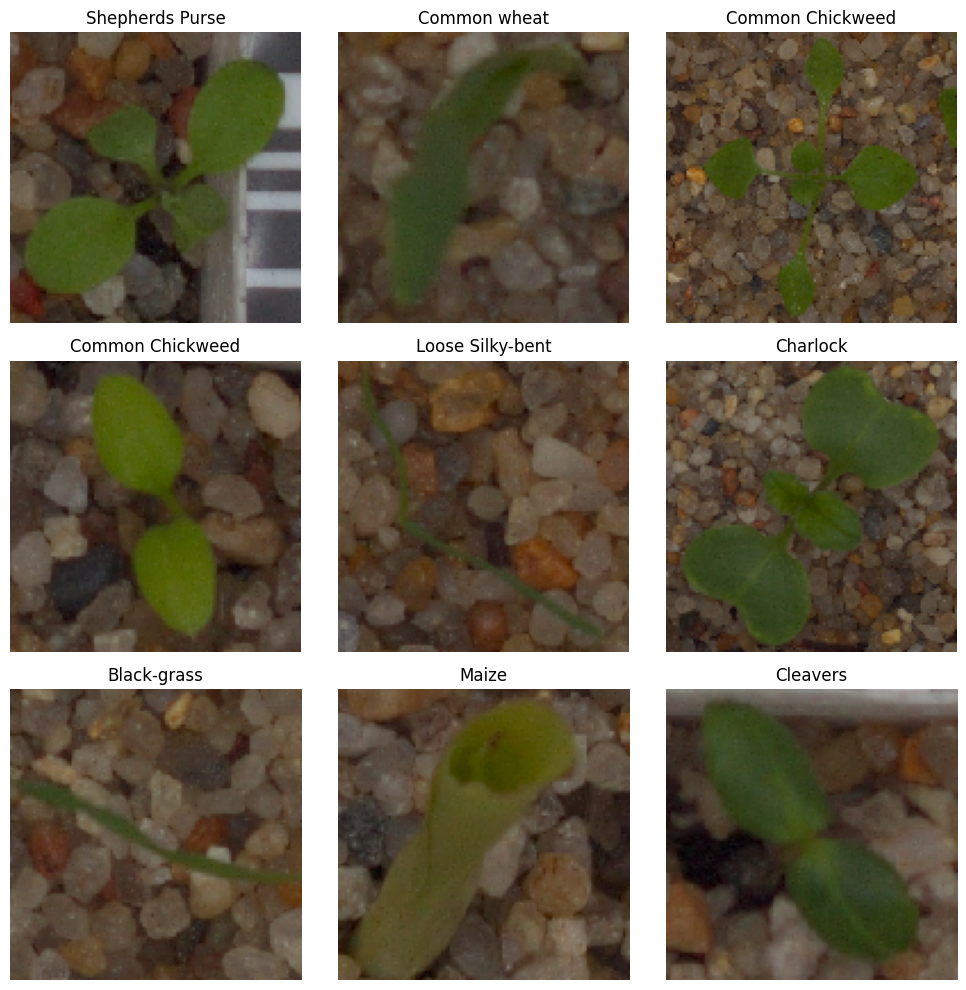

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels from train_generator
images, labels = next(train_generator)

class_labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    plt.title(class_labels[label_index])
    plt.axis("off")
plt.tight_layout()
plt.show()


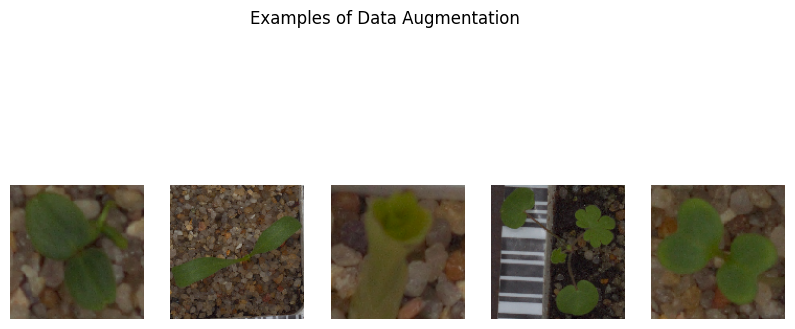

In [35]:
aug_images, _ = next(train_generator)  # already includes augmentation
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(aug_images[i])
    plt.axis("off")
plt.suptitle("Examples of Data Augmentation")
plt.show()


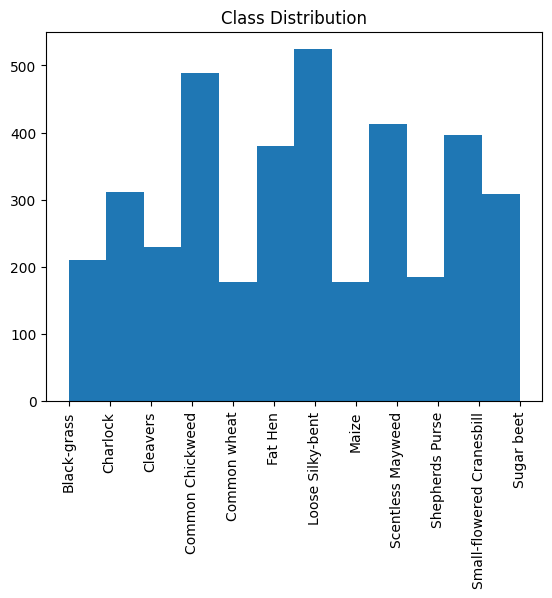

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Plot class balance
class_counts = train_generator.classes
plt.hist(class_counts, bins=len(train_generator.class_indices))
plt.xticks(range(len(train_generator.class_indices)),
           list(train_generator.class_indices.keys()), rotation=90)
plt.title("Class Distribution")
plt.show()


In [37]:
test_generator = test_datagen.flow_from_directory(
    'dataset',              # parent directory
    classes=['test'],       # manually point to test folder
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,        # no labels
    shuffle=False           # keep order so filenames align with predictions
)


Found 794 images belonging to 1 classes.


In [38]:
def build_cnn(input_shape=(128,128,3), num_classes=12):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2,2)),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [39]:
#Initialize model
cnn_model = build_cnn()
cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,188 (12.61 MB)

 Trainable params: 3,306,188 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#Setup callbacks (Early Stopping + Save Best Model)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_cnn_model.keras", save_best_only=True, monitor="val_loss")

In [41]:
#Train the model
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.2020 - loss: 2.3146 - val_accuracy: 0.4372 - val_loss: 1.7704
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.4226 - loss: 1.7298 - val_accuracy: 0.5502 - val_loss: 1.4470
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.5029 - loss: 1.4823 - val_accuracy: 0.6494 - val_loss: 1.1260
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5779 - loss: 1.2395 - val_accuracy: 0.6917 - val_loss: 0.9794
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6165 - loss: 1.1227 - val_accuracy: 0.6948 - val_loss: 1.0096
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.6288 - loss: 1.0126 - val_accuracy: 0.7170 - val_loss: 0.8493
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.6782 - loss: 0.8899 - val_accuracy: 0.7297 - val_loss: 0.8496
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6946 - loss: 0.8378 - val_accu

In [42]:
#Evaluate on validation data
val_loss, val_acc = cnn_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step - accuracy: 0.8205 - loss: 0.5966
Validation Accuracy: 0.82


In [43]:
from tensorflow.keras.models import load_model
import pandas as pd

# Load the saved model
best_model = load_model("best_cnn_model.keras")

# Predict on test data
pred_probs = best_model.predict(test_generator, verbose=1)
pred_classes = pred_probs.argmax(axis=1)

# Map predictions to class labels
class_labels = list(train_generator.class_indices.keys())
pred_labels = [class_labels[i] for i in pred_classes]

# Save results
filenames = test_generator.filenames
results = pd.DataFrame({"filename": filenames, "prediction": pred_labels})
results.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv")



25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step
Predictions saved to test_predictions.csv


In [44]:
#Download test results

from google.colab import files
files.download("test_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

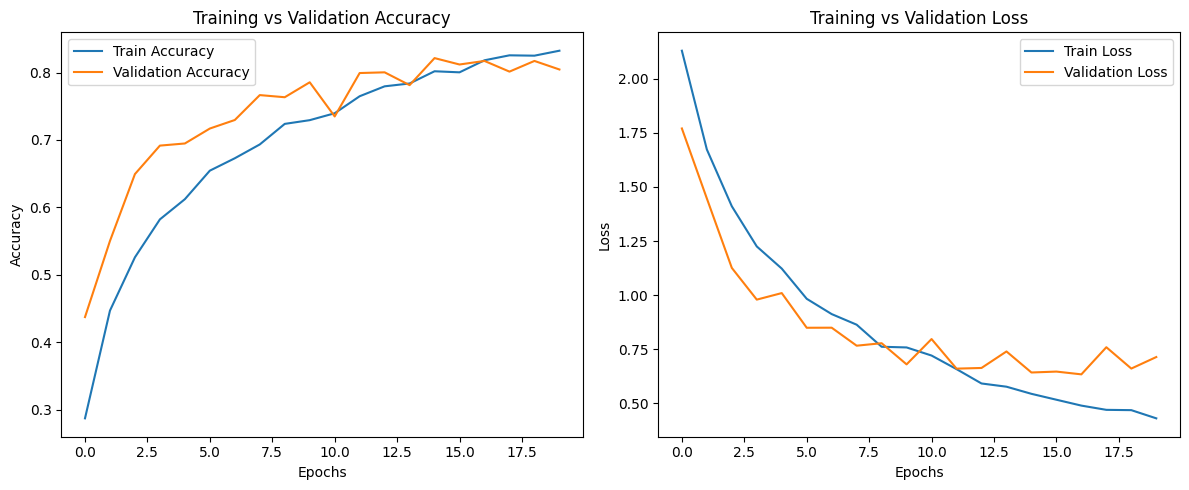

In [45]:
#Visualise training history

import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**CNN + SVM**

In [46]:
from tensorflow.keras.models import Sequential

# Load the trained CNN
from tensorflow.keras.models import load_model
cnn_model = load_model("best_cnn_model.keras")

# Create a feature extractor by removing the last layer (softmax)
feature_extractor = Sequential(cnn_model.layers[:-1])

# Extract features from train and validation sets
train_features = feature_extractor.predict(train_generator, verbose=1)
train_labels = train_generator.classes

val_features = feature_extractor.predict(val_generator, verbose=1)
val_labels = val_generator.classes

print("Feature extraction completed!")


119/119 ━━━━━━━━━━━━━━━━━━━━ 69s 576ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 554ms/step
Feature extraction completed!


In [47]:
#Train CNN + SVM
svm_clf = SVC(kernel='linear', probability=True)
svm_clf.fit(train_features, train_labels)

SVC(kernel='linear', probability=True)

In [48]:
# Predict on validation
val_preds_svm = svm_clf.predict(val_features)

In [49]:
# Evaluation
print("CNN + SVM Accuracy:", accuracy_score(val_labels, val_preds_svm))
print("Classification Report:", classification_report(val_labels, val_preds_svm,target_names=list(train_generator.class_indices.keys())))

CNN + SVM Accuracy: 0.12882787750791974
Classification Report:                            precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        52
                 Charlock       0.00      0.00      0.00        78
                 Cleavers       0.00      0.00      0.00        57
         Common Chickweed       0.13      0.42      0.20       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.23      0.06      0.10        95
         Loose Silky-bent       0.13      0.45      0.21       130
                    Maize       0.00      0.00      0.00        44
        Scentless Mayweed       0.08      0.03      0.04       103
          Shepherds Purse       0.00      0.00      0.00        46
Small-flowered Cranesbill       0.08      0.04      0.05        99
               Sugar beet       0.00      0.00      0.00        77

                 accuracy                           0.13       9

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
#Train CNN + XGBoost

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(train_features, train_labels)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [12:09:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [51]:
# Predict on validation
val_preds_xgb = xgb_clf.predict(val_features)

In [52]:
# Evaluation
print("CNN + XGBoost Accuracy:", accuracy_score(val_labels, val_preds_xgb))
print(classification_report(val_labels, val_preds_xgb, target_names=train_generator.class_indices.keys()))


CNN + XGBoost Accuracy: 0.1119324181626188
                           precision    recall  f1-score   support

              Black-grass       0.04      0.02      0.03        52
                 Charlock       0.05      0.03      0.03        78
                 Cleavers       0.00      0.00      0.00        57
         Common Chickweed       0.14      0.22      0.17       122
             Common wheat       0.00      0.00      0.00        44
                  Fat Hen       0.11      0.11      0.11        95
         Loose Silky-bent       0.14      0.22      0.18       130
                    Maize       0.00      0.00      0.00        44
        Scentless Mayweed       0.10      0.16      0.12       103
          Shepherds Purse       0.13      0.04      0.07        46
Small-flowered Cranesbill       0.12      0.12      0.12        99
               Sugar beet       0.10      0.09      0.09        77

                 accuracy                           0.11       947
                m

In [53]:
#Collect predictions

#Baseline CNN
val_probs_cnn = cnn_model.predict(val_generator, verbose=1)
val_preds_cnn = val_probs_cnn.argmax(axis=1)

#CNN + SVM
val_preds_svm = svm_clf.predict(val_features)

#CNN + XGBoost
val_preds_xgb = xgb_clf.predict(val_features)

#True labels
val_labels = val_generator.classes

#Build comparison table
results = {
    "Model": ["Baseline CNN", "CNN+SVM", "CNN+XGBoost"],
    "Accuracy": [
        accuracy_score(val_labels, val_preds_cnn),
        accuracy_score(val_labels, val_preds_svm),
        accuracy_score(val_labels, val_preds_xgb)
    ],
    "F1-score": [
        f1_score(val_labels, val_preds_cnn, average="micro"),
        f1_score(val_labels, val_preds_svm, average="micro"),
        f1_score(val_labels, val_preds_xgb, average="micro")
    ],
    "Precision": [
        precision_score(val_labels, val_preds_cnn, average="micro"),
        precision_score(val_labels, val_preds_svm, average="micro"),
        precision_score(val_labels, val_preds_xgb, average="micro")
    ],
    "Recall": [
        recall_score(val_labels, val_preds_cnn, average="micro"),
        recall_score(val_labels, val_preds_svm, average="micro"),
        recall_score(val_labels, val_preds_xgb, average="micro")
    ]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df)


30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 562ms/step
Model Comparison:
          Model  Accuracy  F1-score  Precision    Recall
0  Baseline CNN  0.097149  0.097149   0.097149  0.097149
1       CNN+SVM  0.128828  0.128828   0.128828  0.128828
2   CNN+XGBoost  0.111932  0.111932   0.111932  0.111932


In [54]:
#Optional: Predict on unlabeled test data & save CSV

best_model = load_model("best_cnn_model.keras")
pred_probs_test = best_model.predict(test_generator, verbose=1)
pred_classes_test = pred_probs_test.argmax(axis=1)

class_labels = list(train_generator.class_indices.keys())
pred_labels_test = [class_labels[i] for i in pred_classes_test]

filenames = test_generator.filenames
results_test = pd.DataFrame({"filename": filenames, "prediction": pred_labels_test})
results_test.to_csv("test_predictions.csv", index=False)
print(" Test predictions saved to test_predictions.csv")


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step
 Test predictions saved to test_predictions.csv


**Multi-class ROC Curves**

In [55]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

#Binarize the labels for multi-class ROC
num_classes = len(train_generator.class_indices)
y_val_bin = label_binarize(val_labels, classes=range(num_classes))



In [56]:
#Prepare predicted probabilities
#CNN
y_score_cnn = val_probs_cnn

#SVM: need probability=True in SVC
y_score_svm = svm_clf.predict_proba(val_features)

#XGBoost
y_score_xgb = xgb_clf.predict_proba(val_features)



In [57]:
#Function to plot ROC for multi-class
def plot_multiclass_roc(y_true, y_score, title):
    plt.figure(figsize=(8,6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()



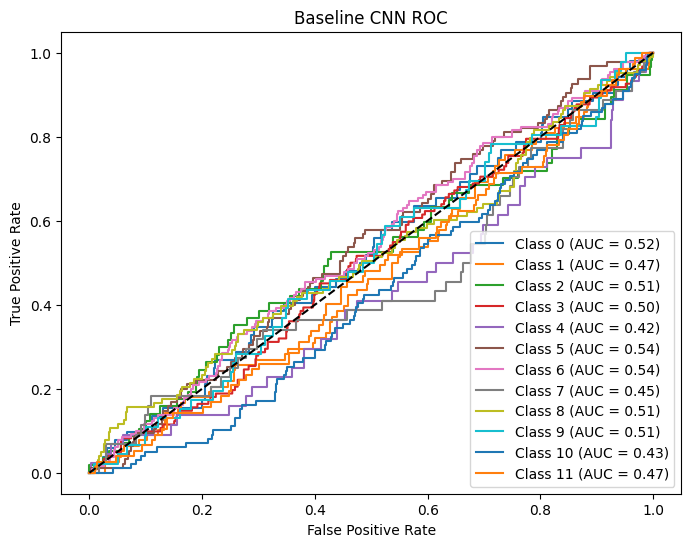

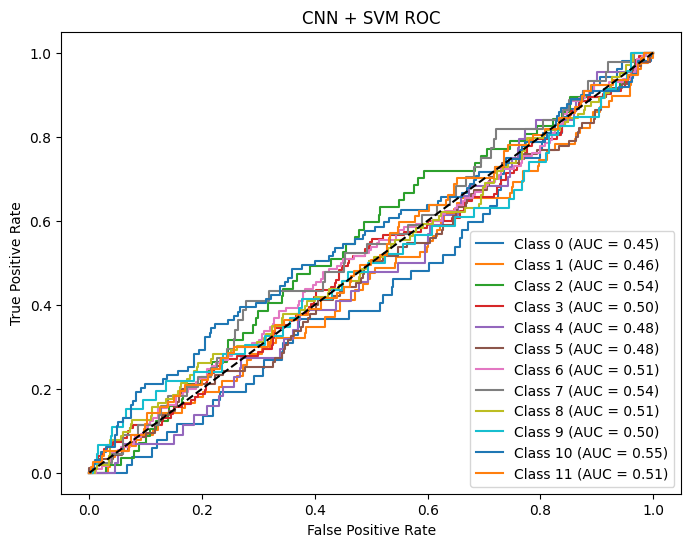

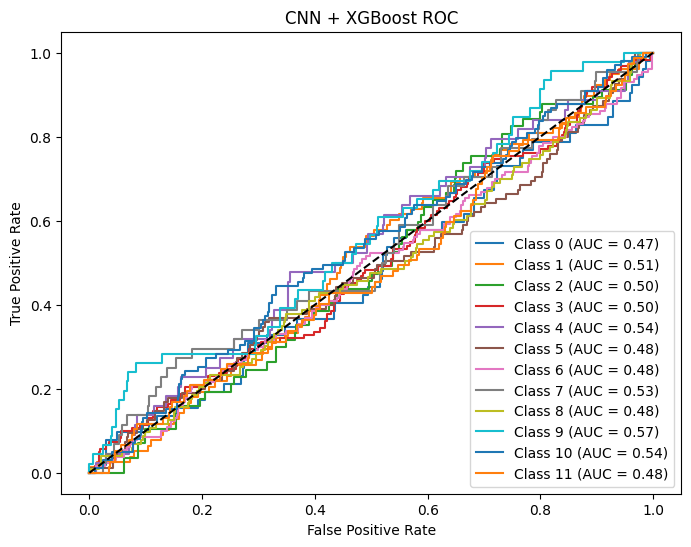

In [58]:
#Plot ROC for all three models
plot_multiclass_roc(y_val_bin, y_score_cnn, "Baseline CNN ROC")
plot_multiclass_roc(y_val_bin, y_score_svm, "CNN + SVM ROC")
plot_multiclass_roc(y_val_bin, y_score_xgb, "CNN + XGBoost ROC")


In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize the labels for multi-class ROC
num_classes = len(train_generator.class_indices)
y_val_bin = label_binarize(val_labels, classes=range(num_classes))

# Prepare predicted probabilities
# CNN
y_score_cnn = val_probs_cnn

# SVM: ensure probability=True in SVC
y_score_svm = svm_clf.predict_proba(val_features)

# XGBoost
y_score_xgb = xgb_clf.predict_proba(val_features)

# Function to compute ROC values and AUC for multi-class
def multiclass_roc_values(y_true, y_score, model_name):
    roc_dict = {}
    for i in range(num_classes):
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        roc_dict[f'class_{i}'] = {
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds,
            'auc': roc_auc
        }
    print(f"\n=== {model_name} ROC AUC per class ===")
    for cls, vals in roc_dict.items():
        print(f"{cls}: AUC = {vals['auc']:.4f}")
    return roc_dict

# Compute ROC values for each model
roc_cnn = multiclass_roc_values(y_val_bin, y_score_cnn, "CNN")
roc_svm = multiclass_roc_values(y_val_bin, y_score_svm, "CNN+SVM")
roc_xgb = multiclass_roc_values(y_val_bin, y_score_xgb, "CNN+XGBoost")



=== CNN ROC AUC per class ===
class_0: AUC = 0.5180
class_1: AUC = 0.4722
class_2: AUC = 0.5092
class_3: AUC = 0.4961
class_4: AUC = 0.4171
class_5: AUC = 0.5370
class_6: AUC = 0.5356
class_7: AUC = 0.4504
class_8: AUC = 0.5132
class_9: AUC = 0.5059
class_10: AUC = 0.4253
class_11: AUC = 0.4674

=== CNN+SVM ROC AUC per class ===
class_0: AUC = 0.4484
class_1: AUC = 0.4642
class_2: AUC = 0.5412
class_3: AUC = 0.4998
class_4: AUC = 0.4766
class_5: AUC = 0.4792
class_6: AUC = 0.5104
class_7: AUC = 0.5360
class_8: AUC = 0.5071
class_9: AUC = 0.4959
class_10: AUC = 0.5522
class_11: AUC = 0.5110

=== CNN+XGBoost ROC AUC per class ===
class_0: AUC = 0.4745
class_1: AUC = 0.5080
class_2: AUC = 0.4955
class_3: AUC = 0.4970
class_4: AUC = 0.5379
class_5: AUC = 0.4776
class_6: AUC = 0.4813
class_7: AUC = 0.5273
class_8: AUC = 0.4793
class_9: AUC = 0.5659
class_10: AUC = 0.5367
class_11: AUC = 0.4835
